**Problem Statement**

Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



**Importing Libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

**Loading Dataset using Google Drive in Google Colab**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/CNN_assignment"

Archive:  /content/gdrive/My Drive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflatin

In [4]:
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# Analysing dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

create a code to visualize one instance of all the nine classes present in the dataset

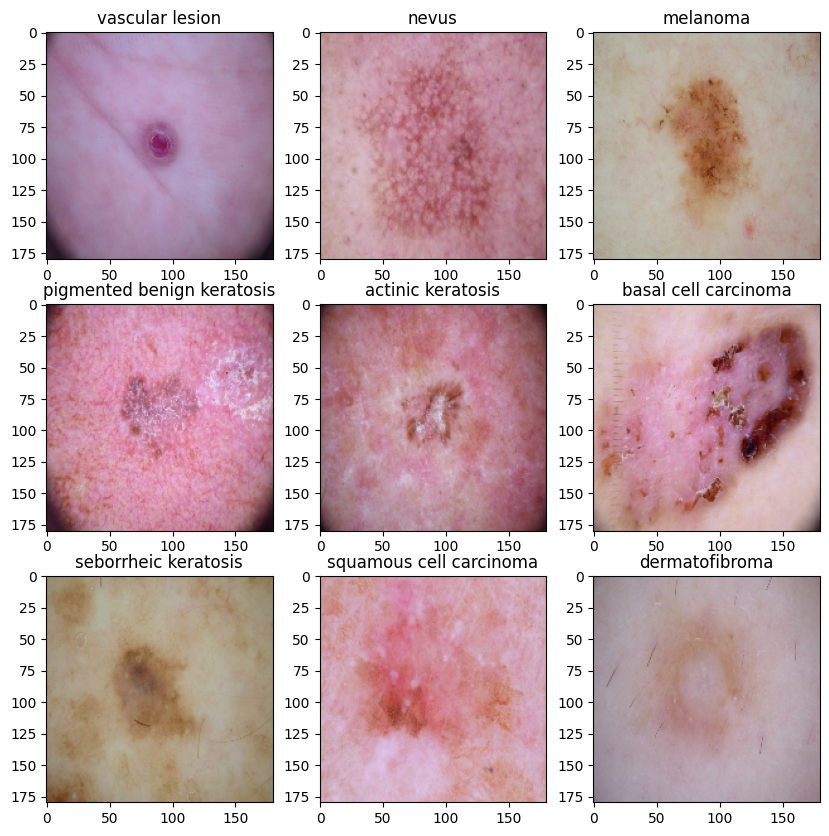

In [10]:
# Visualising dataset, one sample from each class
label=train_ds.class_names
import matplotlib.pyplot as plt
index=1
label_dict = {key: 0 for key in label}
plt.figure(figsize=(10,10))
for images,labels in train_ds:
    label1=labels[0]
    class_index=tf.argmax(label1)
    if(label_dict[label[class_index]]==0):
        image=images[0]
        plt.subplot(3,3,index)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(label[class_index])
        index=index+1
        label_dict[label[class_index]]+=1
plt.show()


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.


Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
### Your code goes here
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


**Train the model**

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 106ms/step - loss: 3.7033 - accuracy: 0.1680 - val_loss: 2.1435 - val_accuracy: 0.1633
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 1.9097 - accuracy: 0.2885 - val_loss: 1.8762 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7401 - accuracy: 0.3739 - val_loss: 1.8657 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6427 - accuracy: 0.4074 - val_loss: 1.6643 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.5484 - accuracy: 0.4520 - val_loss: 1.6851 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4442 - accuracy: 0.4961 - val_loss: 1.4704 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4564 - accuracy: 0.4933 - val_loss: 1.6173 - val_accuracy: 0.4430
Epoch 8/20


In [15]:
# View the summary of all layers
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

**Visualizing training results**

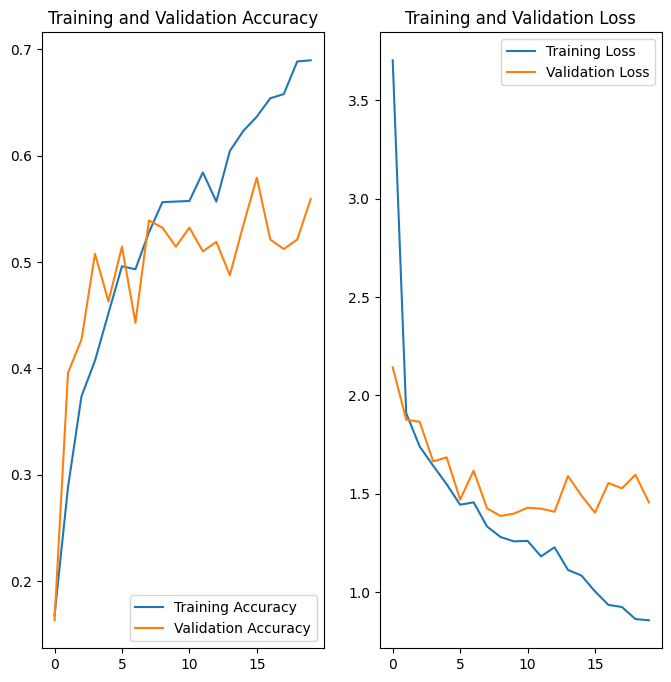

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

***Findings/Observations***

1. The accuracy of the model for the Training data set is at ~70%. But the Validation accuracy is not in par with the training accuracy.
It is only at ~54%.
2. The validation loss as observed is very high. This can also indicate that the model might get overfit.
3. We could add some Dropout layers and remove the BatchNormalization layers. And by adding a few more layers, we could improve the accuracy by trying to extract more features.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])


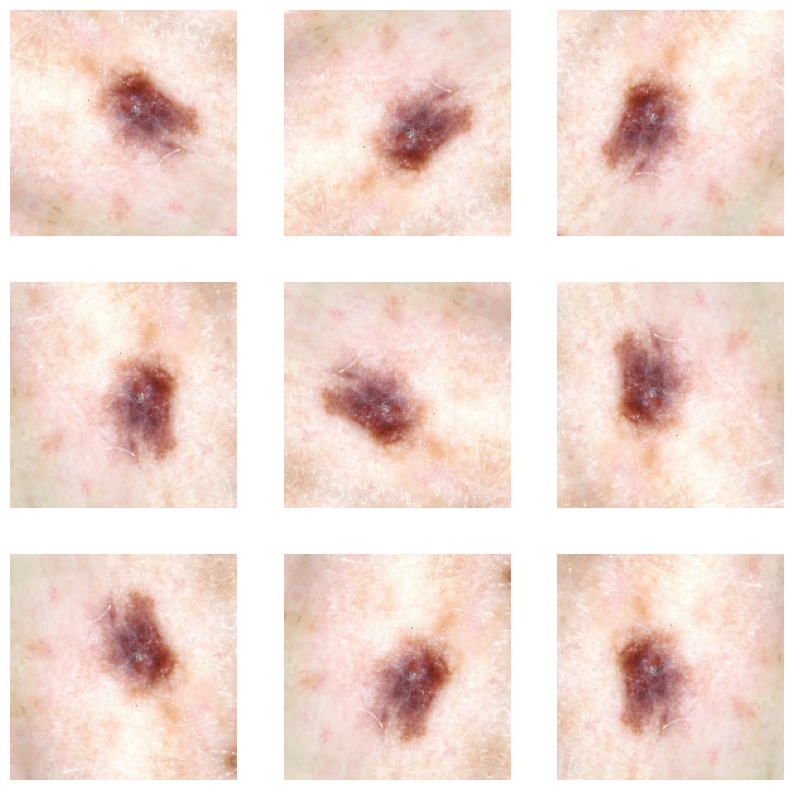

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

image, label = next(iter(train_ds))
image=np.array(image,np.int32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

**Create the model, compile and train the model**

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Compiling the model**


In [20]:
model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Training the model**

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 132ms/step - loss: 2.1214 - accuracy: 0.1920 - val_loss: 2.0311 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0331 - accuracy: 0.1942 - val_loss: 2.0244 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0400 - accuracy: 0.1942 - val_loss: 2.0253 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0310 - accuracy: 0.1914 - val_loss: 2.0362 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 7s 117ms/step - loss: 2.0261 - accuracy: 0.1998 - val_loss: 2.0255 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 7s 119ms/step - loss: 2.0274 - accuracy: 0.2003 - val_loss: 2.0223 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0309 - accuracy: 0.2048 - val_loss: 2.0219 - val_accuracy: 0.2058
Epoch

**Visualizing the results**

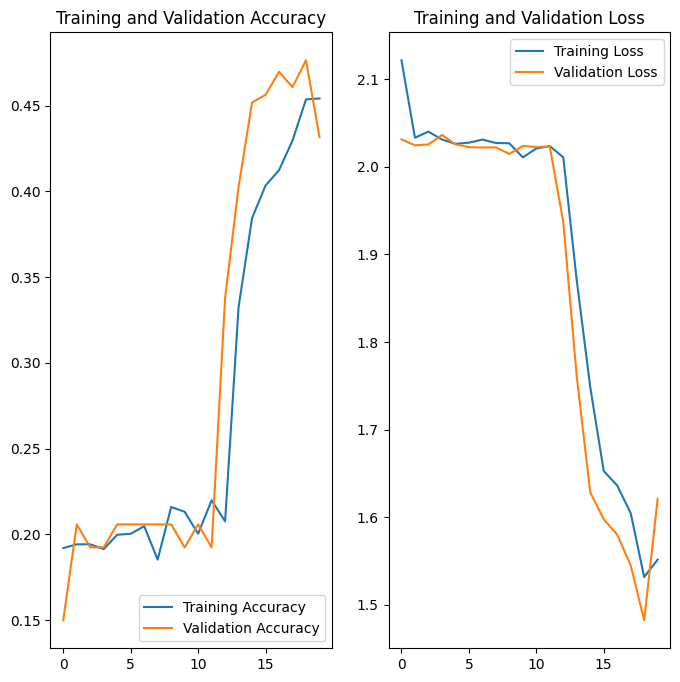

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Findings/Observations***

1. The accuracy for the train set is ~46%

2. The accuracy for the Validation set is also at ~44%.
Though the model accuracy for train and validation data had decreased when compared to the first model, as the accuracy scores are close to each other, this model is better than the first model.

3. Hence, we can say that Data Augmentation has definitely improved the model performance.

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# A function to read training dataset and get image count per subclass
import os

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,nevus,357
2,melanoma,438
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,actinic keratosis,114
6,dermatofibroma,95
7,squamous cell carcinoma,181
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

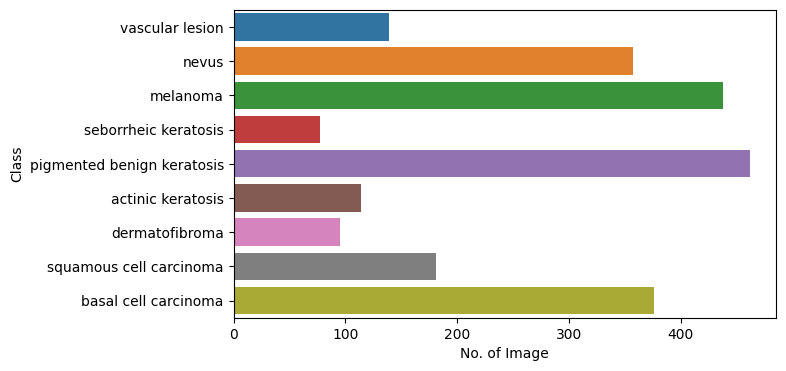

In [24]:
# Visualising image count based on subclasses via barplot
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

Todo: Write your findings here:

*There is a huge different in the number of samples for each class and the data is clearly imbalanced.*

- Which class has the least number of samples?

  Ans: **'seborrheic keratosis'** has got the least number of samples.

- Which classes dominate the data in terms proportionate number of samples?

  Ans: **'pigmented benign keratosis'** has the highest number of samples i.e, 462, followed by 'melanoma' which has 438 samples.*

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.

Define a number of operations to perform on this data set using your Pipeline object.

Execute these operations by calling the Pipeline’s sample() method.

In [26]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BED50F2DEA0>: 100%|██████████| 500/500 [00:23<00:00, 21.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BED50B57FA0>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BED50C5E500>: 100%|██████████| 500/500 [00:25<00:00, 19.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BED50196530>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7BED50B37160>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BED50C0D420>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BED50B54BB0>: 100%|██████████| 500/500 [00:43<00:00, 11.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BED501A99F0>: 100%|██████████| 500/500 [00:16<00:00, 30.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BEDF0CED2D0>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list


['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030722.jpg_9db04e8c-1d4b-4d46-8d0f-936b47ad2a72.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026467.jpg_bedfbd7d-962e-4809-b972-a78d6c42847b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_85ec292b-d786-43ba-a659-cb6871d466b3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_c5a57953-2ba6-48fd-8aa6-0c9a86fb5511.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033991.jpg_cc6bd92f-e412-447a-b79b-96c246fdcafe.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collab

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
for i in class_names:
    directory =path_to_training_dataset+i+'/'
    directory_out =path_to_training_dataset+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo:** Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

**Todo:** Create a training dataset

In [33]:
#data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Todo:** Create your model (make sure to include normalization)

In [35]:
## your code goes here

model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Todo:** Train your model

In [37]:
epochs = 30

history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 55s 291ms/step - loss: 2.7044 - accuracy: 0.1834 - val_loss: 2.0382 - val_accuracy: 0.2502
Epoch 2/30
169/169 [==============================] - 32s 178ms/step - loss: 1.7489 - accuracy: 0.3314 - val_loss: 1.9302 - val_accuracy: 0.2880
Epoch 3/30
169/169 [==============================] - 35s 198ms/step - loss: 1.5160 - accuracy: 0.4297 - val_loss: 1.4347 - val_accuracy: 0.4573
Epoch 4/30
169/169 [==============================] - 32s 187ms/step - loss: 1.3225 - accuracy: 0.5000 - val_loss: 1.2640 - val_accuracy: 0.5249
Epoch 5/30
169/169 [==============================] - 33s 190ms/step - loss: 1.1676 - accuracy: 0.5642 - val_loss: 1.2558 - val_accuracy: 0.5442
Epoch 6/30
169/169 [==============================] - 29s 167ms/step - loss: 1.0411 - accuracy: 0.6207 - val_loss: 1.1183 - val_accuracy: 0.5991
Epoch 7/30
169/169 [==============================] - 32s 178ms/step - loss: 0.9030 - accuracy: 0.6660 - val_loss: 1.0029 - val_ac

**Todo:** Visualize the model results

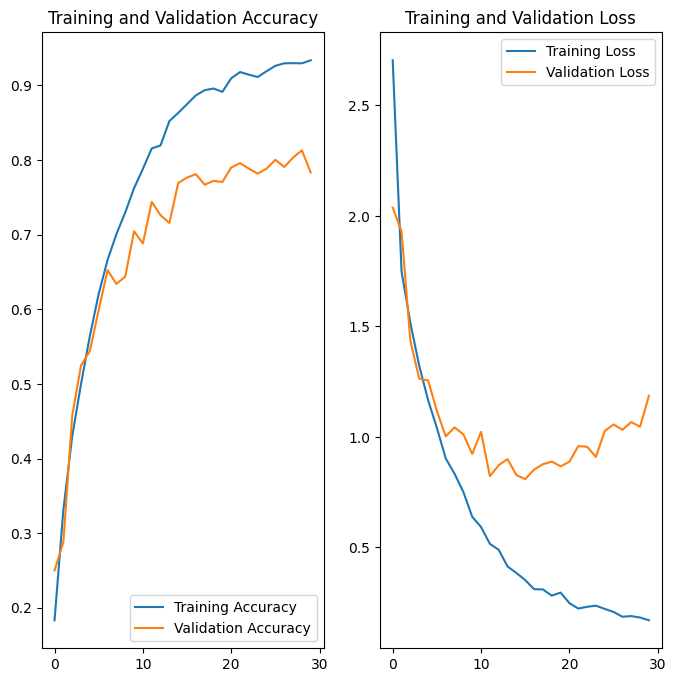

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



**Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

***Findings/Observations:***
1. The training accuracy seems to be nearly ~93%.
2. The validation accuracy is nearly ~80%.
3. **Though the model accuracy has improved, the augmentation and class rebalance has helped treat the overfitting.**

**Model Predictions**

Predictions on the test data using this model

Found 6739 files belonging to 9 classes.
Found 118 files belonging to 9 classes.
{'actinic keratosis': 0, 'basal cell carcinoma': 0, 'dermatofibroma': 0, 'melanoma': 0, 'nevus': 0, 'pigmented benign keratosis': 0, 'seborrheic keratosis': 0, 'squamous cell carcinoma': 0, 'vascular lesion': 0}
1/1 [==============================] - 0s 69ms/step


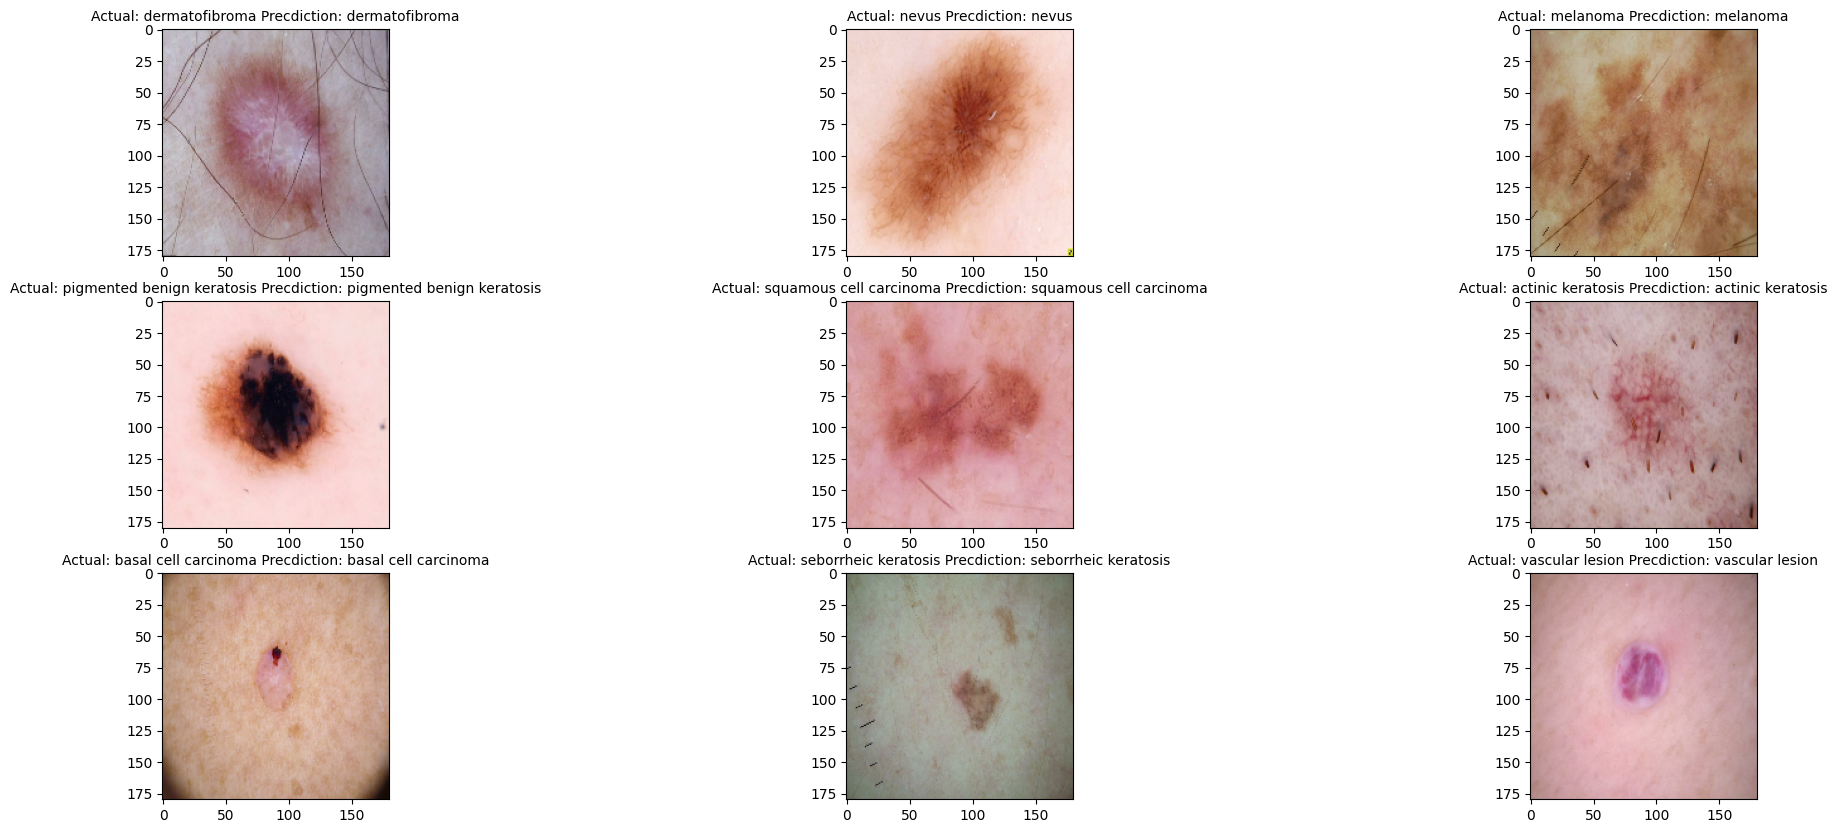

In [41]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

#Using keras to read dataset
mel_dataset=tf.keras.utils.image_dataset_from_directory(data_dir_train,labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    seed=123)

# Loading the Test Dataset for model predictions
mel_test_dataset=tf.keras.utils.image_dataset_from_directory(data_dir_test,labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    seed=123)

label_test=mel_test_dataset.class_names


# Class Wise prediction for Test dataset
index=1
label_test_dict = {key: 0 for key in label_test}
plt.figure(figsize=(25,10))
print(label_test_dict)
for images,labels in mel_dataset:
    label1=labels[0]
    class_index=tf.argmax(label1)
    if(label_test_dict[label_test[class_index]]==0):
        image=images[0]
        # Predicting for image from each class
        img = np.expand_dims(image,axis=0)
        pred = model_final.predict(img)
        pred = np.argmax(pred)
        pred_class = label_test[pred]
        plt.subplot(3,3,index)
        plt.imshow(image.numpy().astype("uint8"))
        # Displaying Predicted class of Image in Title along with the actual class of image
        plt.title("Actual: "+label_test[class_index]+" Precdiction: "+pred_class,fontsize=10)
        index=index+1
        label_test_dict[label_test[class_index]]+=1

plt.show()

**Observations:**
1. If we obesrve the text above the images here, we can see that that actual and the predicted values are correct.Model is able to predict well. Eg: **Image-1** the **Actual** value is **dermatofibroma** and the **Predicted** value is also **dermatofibroma**
2. **Model Accuracy:**

  Validation Accuracy: 80%

  Traning Accuracy: 93%
